# Feature Importance

In Machine Learning, feature importance gives (usually just) a relative ranking of the predictive strength among the features of the model; useful for simplifying models and possibly improving generality. It helps us better understand the relationship between features & the target variable and features & features. When traning the model, some features may be highly correlated, which results in multicollinearity. After filtering out the correlated features, the model's performance may increase significantly. By calculating feature importance, you can determine which features is impacts the target variables the most. In this report, we will discuss multiple methods of calculating feature importance and build a automatic function calculating feature importance.

In [3]:
%run featimp

## Load Dataset 
This report mainly uses Boston data from scikit-learn. This step splits the whold dataset to train and valid set.

In [5]:
from sklearn.datasets import load_boston
data = load_boston()
features = data.feature_names

In [6]:
df_x_train,df_x_val,y_train,y_val,X_train,X_val,features = generate_x_y(data)

The explanation of each features are shown below:

- CRIM - This is the average per person crime rate by town.
- ZN - This is the extent of private land zoned for lots over 25,000 square feet.
- INDUS - This is the extent of non-retail business sections of land per town.
- CHAS - It is considered to be 1 if tract bounds river, otherwise it’s always 0.
- NOX - This refers to the Nitric Oxide concentration.
- RM - This is the average number of rooms per residence.
- AGE - This is the extent of proprietor-involved units worked before 1940.
- DIS - This is the weighted distance to five Boston business focuses.
- RAD - This is the index of access to radial highways.
- TAX - This is the property tax rate (full-value) per $10,000.
- PRATIO - This tells the student-teacher ratio.
- B - B is calculated by 1000(Bk-0.63)^2. Bk denotes the proportion of black people by town.
- LSTAT - This tells us the percent lower status of the population.

The feature of X are : __CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT__

## Methods of Calculating Feature Importance

### The first __three__ methods discussed below are categorized as __Fixed Feature Importance__: calculating feature importance based on dataset. They do not change when using different models.

### 1) Spearman's Rank Coefficient

Simplest technique for regression is to rank x features by their Spearman's rank correlation with target y. But the drawback of this method is that it does not take multicollinearity into account. It only considers the relationship between each feature and the target variable.

In [6]:
spearman = spearman_fi(X_train,y_train,features)

The feature importance plot is shown below:

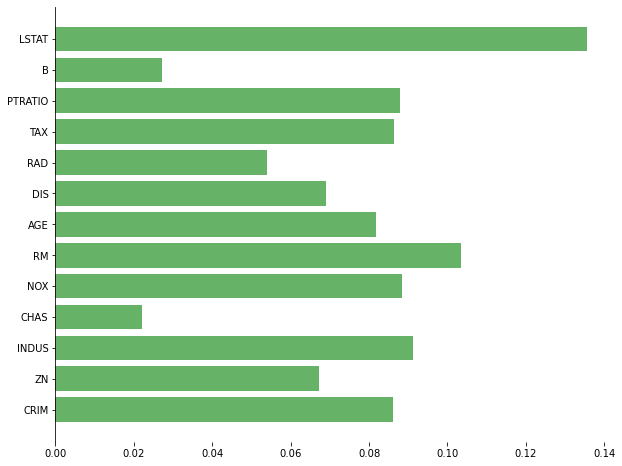

In [7]:
plot_bar(spearman)

### 2) PCA

Principle component analysis (PCA) operates on just the 𝑋 explanatory matrix, limited to linear relationships and "most variance" is not always the same as "most important". PCA transforms data into a new space characterized by eigenvectors of X and identifies features that explain the most variance in the new space. As the heatmap shown below, over 95% of variance can be explained by the first 9 PC and each feature contributes differently to each PC.

In [8]:
pca = pca_fi(features,X_train)

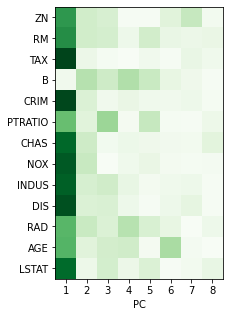

In [47]:
from IPython.display import Image
Image(filename='Images/PCA.png') 

For this dataset, the first component analysis explained about 46% of the variance. I use the magnitude each feature explained the first component analysis.

The feature importance plot is shown below:

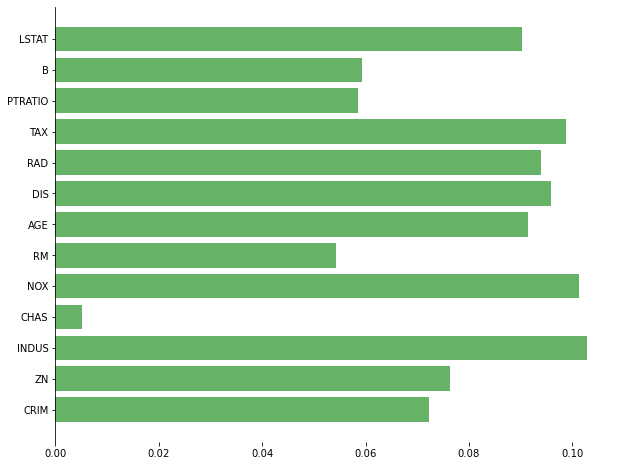

In [9]:
plot_bar(pca)

### 3) mRmR

mRMR (minimal-redundancy maximal-relevance) deals with codependencies, rank not just by relevance but also
by redundance. The basic algorithms is shown below.

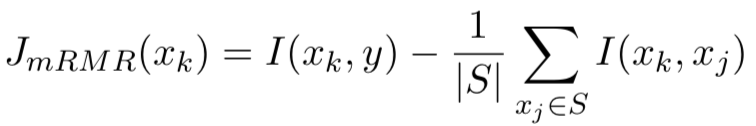

In [48]:
from IPython.display import Image
Image(filename='Images/mRMR.png') 

In [11]:
mRmR = mRmR_fi(df_x_train,y_train,features)

The feature importance plot is shown below:

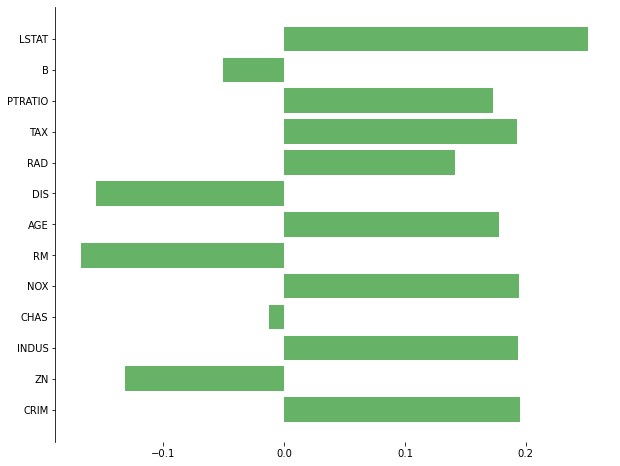

In [12]:
plot_bar(mRmR)

### The __two__ methods discussed below are categorized as __Model Based Feature Importance__: calculating feature importance based on model.

### 4) Drop Column Importance

By droping each column and rerun the model, we can calculate the diffence of the validation loss with and without the specific feature. The procedures are shown below:

1. Compute validation metric for model trained on all features 
2. Drop column 𝑥 from training set
3. Retrainmodel
4. Computevalidationmetricset
5. Importancescoreisthechangeinmetric

I used model = XGBRegressor() here to show the feature importance.

In [13]:
model = XGBRegressor()
drop_ = dropcol_importances(model,df_x_train, y_train, df_x_val, y_val)

The feature importance plot is shown below:

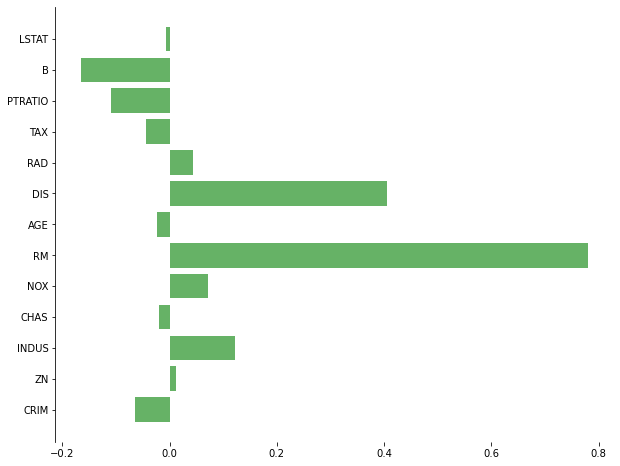

In [14]:
plot_bar(drop_)

### 5) Permutation Column Importance

By permutating each column in validation set, we can calculate the diffence of the validation loss with and without the specific feature. The procedures are shown below:

1. Compute validation metric for model trained on all features 
2. Permute column 𝑥 in validation set
3. Computevalidationmetricset
4. Importancescoreisthechangeinmetric

In [17]:
model = XGBRegressor()
model.fit(X_train,y_train)
permu_ = permutation_importances(model,df_x_val, y_val)

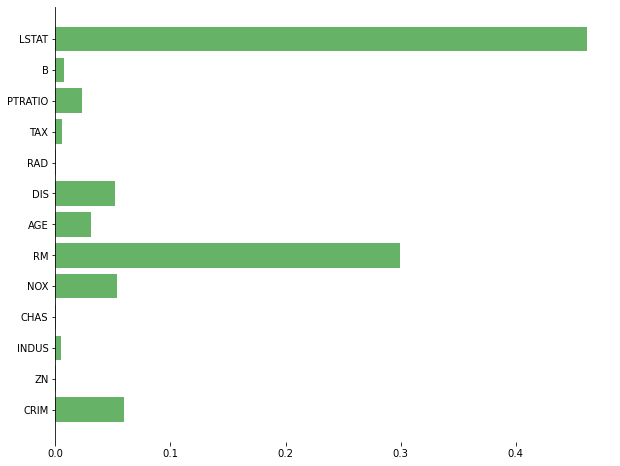

In [18]:
plot_bar(permu_)

## Testing 5 methods on Different ML Models

Now, since we've already have 5 methods of calculating feature importance, we will now try to explore the effectiveness of each method when using different models. Here, we will use XGBoost, RandomForest, and Linear Regression. From the graphs below, x-axis represents number of features and y-axis represents MAE loss. 

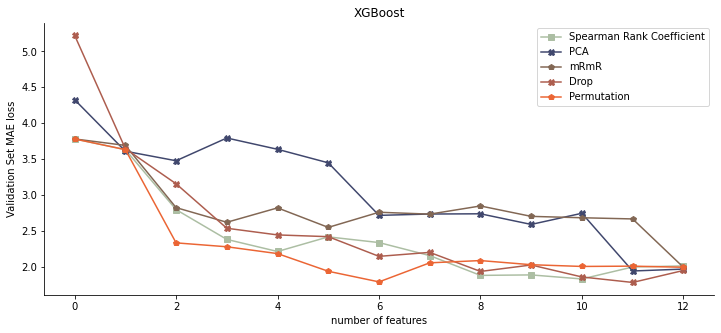

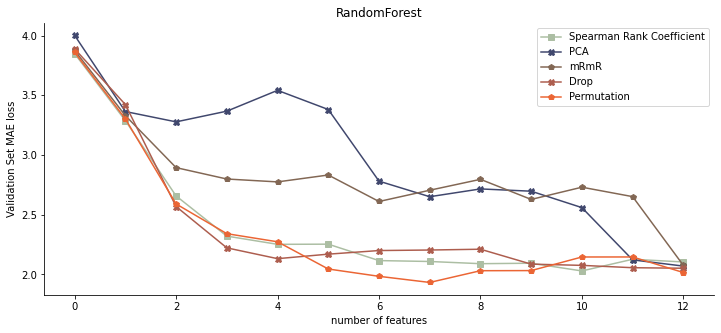

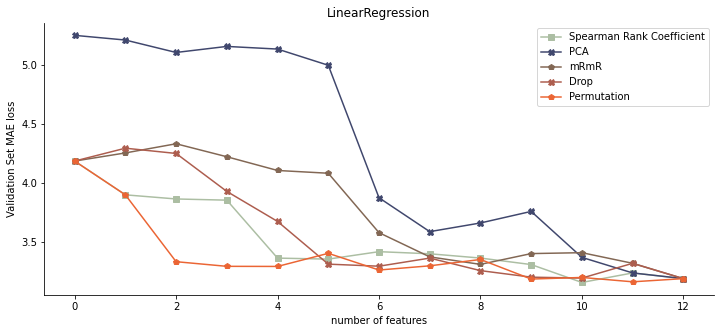

In [19]:
plot_diff_fi_methods([spearman,pca,mRmR],13,df_x_train,df_x_val,y_train,y_val)

From the above plot, we can see that permutation column feature importances generate the lowest MAE loss in all three models. Thus, we will use permutation colomn feature importances as our selected method to calculate feature importances and will do more research on feature importances based on this method.

Below is the another method of calculating feature importances. __SHAP__ (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

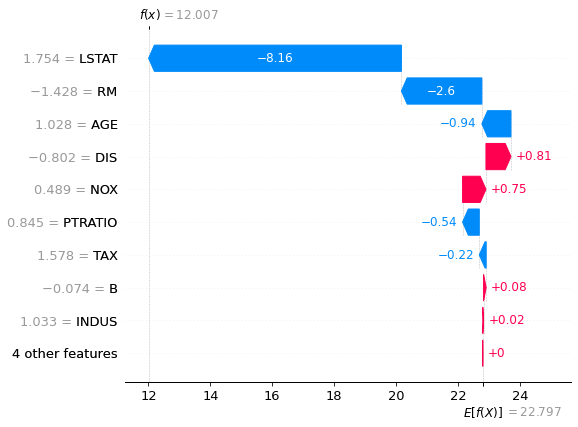

In [77]:
import shap
model = XGBRegressor().fit(df_x_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(df_x_train)
shap.plots.waterfall(shap_values[0])

## Automatic feature selection algorithm

After calculating a score for each feature representing their importances. We want to implement an automated mechanism that selects the top k features automatically that gives the best validation error. The algorithm is shown below:
- Step1: Calculate feature importance using permutation method
- Step2: Calculate the Validation Loss using MAE with all features selected
- Step3: Drop a feature that has the lowest importance score
- Step4: Redo Step2 and Step4 until MAE loss increases more than 0.1
- Step5: Return the final features selected

['LSTAT', 'RM', 'DIS', 'NOX', 'CRIM', 'AGE', 'PTRATIO', 'B']

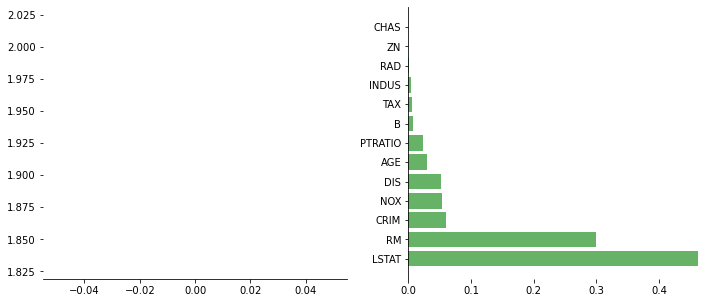

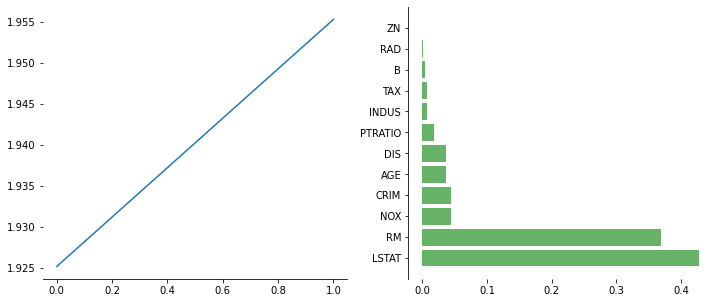

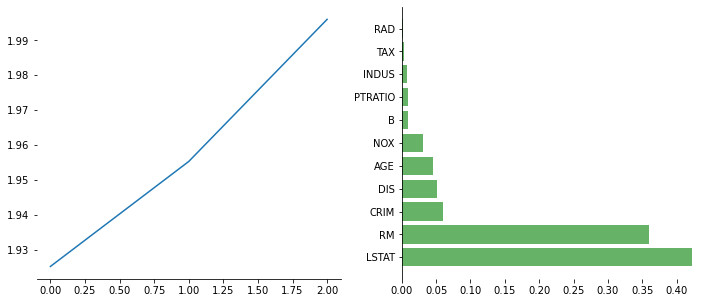

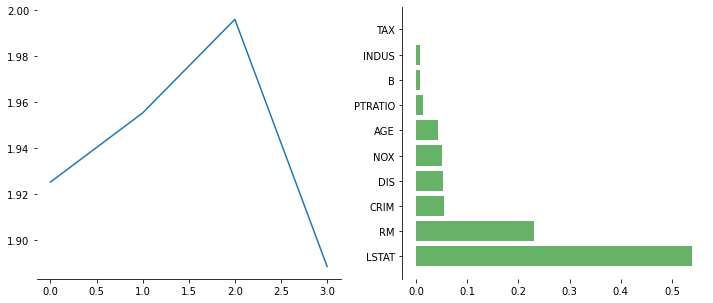

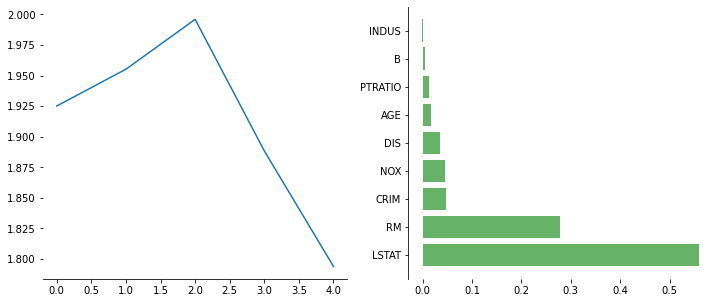

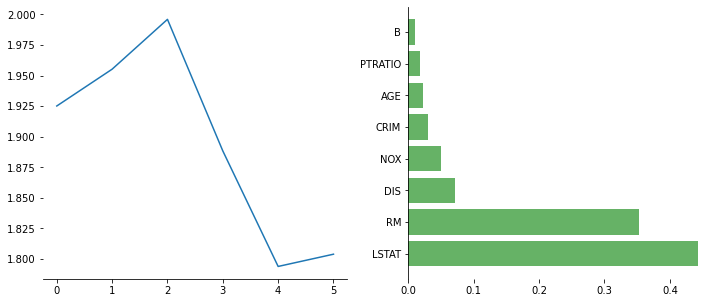

In [49]:
model = XGBRegressor()
select_K(permu_,model,df_x_train,y_train,df_x_val,y_val)

The selected features are : __'LSTAT', 'RM', 'DIS', 'NOX', 'CRIM', 'AGE', 'PTRATIO', 'B'__

# Variance and empirical p-values for feature importances 

By boostrapping X and y, we are able to get the standard deviation of feature importances. This is helpful when selecting important features as well. The graph below shows error bars representing standard deviation of each features.

In [29]:
std = bootstrap(50,X_train,y_train,features,df_x_val,y_val)

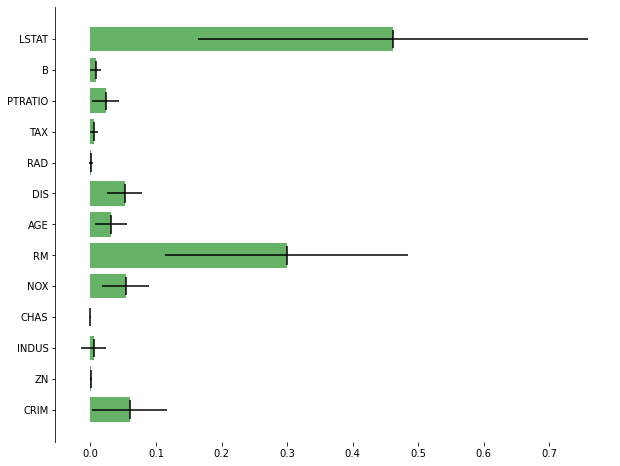

In [31]:
plot_bar_error(permu_,std)

It's also useful to get p-values to know whether a feature's importance is significant. To do that, we need a null distribution for comparison purposes. I shuffled the target variable y, and then compute the feature importances again. By doing this 80 times, we will get the distribution of each features. "LSTAT" and "RM"'s distributions are shown below.

In [7]:
actual_imp_df = get_feature_importances(df_x_train,y_train,df_x_val,y_val,features, shuffle=True, seed=None)

In [8]:
null_imp_df = rerun(80,df_x_train,y_train,df_x_val,y_val,features, shuffle=True, seed=None)

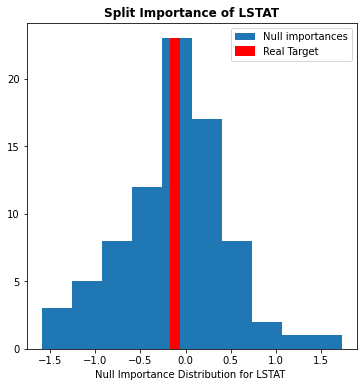

In [9]:
display_distributions(actual_imp_df, null_imp_df, 'LSTAT')

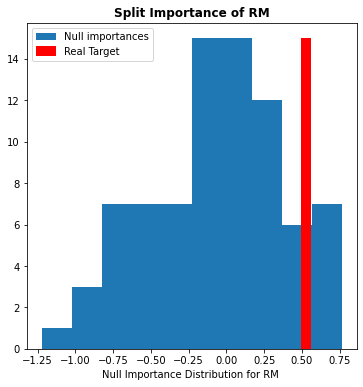

In [10]:
display_distributions(actual_imp_df, null_imp_df, 'RM')

## Conclusion

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. There are many types and sources of feature importance scores, and this report mainly introduces five of them. Among these five methods, the "permutation column" method seems to be most useful and generate the best results. This report also shows an algorithm that automatically select K features using permutation method. Other than that, when considering feature importances, standard deviation and p-values are useful to take into consideration.

## References
- https://github.com/slundberg/shap
- https://github.com/parrt/msds689/blob/master/projects/featimp/featimp.md
- https://www.educative.io/edpresso/what-is-sklearndatasetsloadboston-star-returnxy
- https://machinelearningmastery.com/calculate-feature-importance-with-python/